In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow import keras as k
import random
from tqdm import tqdm
import shutil
import datetime, os
tf.random.set_seed(1)

cwd = os.getcwd()
primary_dir = os.fsencode(cwd)

shutil.rmtree("/Users/joshking/Dropbox/Quantum/logs")
logs_base_dir = "/Users/joshking/Dropbox/Quantum/logs"
os.makedirs(logs_base_dir, exist_ok=True)

%reload_ext tensorboard
%tensorboard --logdir {logs_base_dir}

tensorboard_callback = k.callbacks.TensorBoard(log_dir=logs_base_dir,update_freq='epoch',embeddings_freq=0,
                                               profile_batch = 0)
writer = tf.summary.create_file_writer("/Users/joshking/Dropbox/Quantum/logs")

Reusing TensorBoard on port 6006 (pid 29261), started 3 days, 5:22:43 ago. (Use '!kill 29261' to kill it.)

In [4]:
binary_dict = {0: 'No triangle', 1 : 'Bias triangle'}


In [5]:
def create_model(pixel_size=32,dense_layers = [32*2,32],drop_out=0.4,l2=0.0001):
    model = models.Sequential()
    model.add(layers.Conv2D(pixel_size, (3, 3), activation='relu', input_shape=(pixel_size, pixel_size, 1), padding="SAME"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(pixel_size*2, (3, 3), activation='relu', padding="SAME"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(pixel_size*2, (3, 3), activation='relu', padding="SAME"))
    
    model.add(layers.Flatten())
    for dense_layer in dense_layers:
        model.add(layers.Dense(dense_layer, activation='elu',kernel_regularizer=regularizers.l2(l2)))
        model.add(layers.Dropout(drop_out))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

def compile_model(model):
    model.compile(optimizer='adam',
             loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

def train_model(model,train_images,train_labels,test_images,test_labels,epochs,batch_size):
    history = model.fit(train_images,train_labels, epochs=epochs, batch_size=batch_size, 
                        validation_data=(test_images,test_labels)) #callbacks=[tensorboard_callback])
    # ,shuffle=True
    return model, history

def evaluate_model(model,history, test_images,test_labels):
    plt.clf()
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.0, 1.1])
    plt.legend(loc='lower right')
    plt.show()
   
    test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
    return test_loss, test_acc

def normalise(x, y):
    x = tf.image.per_image_standardization(x)
    return x, y

In [6]:
data_total = np.load('/Users/joshking/Documents/01Masters/Data/all_data_16_03_2020.npy')
labels_total = np.load('/Users/joshking/Documents/01Masters/Data/all_labels_16_03_2020.npy')
#/Users/joshking/Dropbox/Quantum/Triangles/normalised_data_matrices_train.npy
#/Users/joshking/Dropbox/Quantum/Triangles/normalised_data_labels_train.npy
#C:/Quantum/Seb_CNN/
# data_total,labels_total = normalise(data_total,labels_total) 

# val_split = 0.2
# val_set = np.int(val_split*np.shape(labels_total)[0])


# train_images= np.array(data_total[val_set:]).reshape(-1, 32, 32, 1)
# train_labels = np.array(labels_total[val_set:]).reshape(-1, 1)
# validate_images = np.array(data_total[:val_set]).reshape(-1, 32, 32, 1) 
# validate_labels = np.array(labels_total[:val_set]).reshape(-1, 1) 

In [9]:
train_images_pre=np.squeeze(train_images)
train_labels_pre=np.squeeze(train_labels)
validate_images_pre=np.squeeze(validate_images)
validate_labels_pre=np.squeeze(validate_labels)

In [7]:
def block_splitting(images):
    #Initialise Array:
    data_array=np.zeros(shape=(len(images),18))
    
    for i in range(len(images)):
        image = np.squeeze(train_images[i])
        #Split into blocks based on manually calculated pixel locations:
        block_1=image[0:16, 0:16]
        block_2=image[16:32, 0:16]
        block_3=image[0:16, 16:32]
        block_4=image[16:32, 16:32]
        block_5=image[8:24, 8:24]
        block_6=image[0:16, 8:24]
        block_7=image[8:24, 0:16]
        block_8=image[8:24, 16:32]
        block_9=image[16:32, 8:24]
        #Concatenate data into single 18-feature array:
        means=np.array([np.mean(block_1),np.mean(block_2),np.mean(block_3),np.mean(block_4),np.mean(block_5),np.mean(block_6),
               np.mean(block_7), np.mean(block_8),np.mean(block_9)])
        stds=np.array([np.std(block_1),np.std(block_2),np.std(block_3),np.std(block_4),np.std(block_5),np.std(block_6),
               np.std(block_7), np.std(block_8),np.std(block_9)])
        combined=np.concatenate((means,stds))
        #print(combined)
        data_array[i]=combined
    return data_array

In [11]:
train_X=block_splitting(train_images_pre)
train_Y=train_labels
valid_X=block_splitting(validate_images_pre)
valid_Y=validate_labels

In [8]:
def min_max(feature_array): #used to find the min and max values of each feature (column) of the array
    data_array = np.zeros(shape=(2,18))
    for j in range(18):
        col = feature_array[:,j]
        data_array[0,j]= col.min(axis=0)
        data_array[1,j]= col.max(axis=0)
    return data_array

In [9]:
def normaliser(feature_array,min_max_array): #Normalises based on the eqaution (x-xmin) / (xmax-xmin)
    norm_feature_array=np.zeros(shape=(len(feature_array),18))
    feature_array_copy=feature_array.copy()
    for i in range(len(feature_array_copy)):
        for j in range(18):
            norm_feature_array[i,j]=((feature_array_copy[i,j]-min_max_array[0,j])/
                                     (min_max_array[1,j]-min_max_array[0,j]))
    return norm_feature_array

In [10]:
def intensity_finder(feature_array): #Finds average pixel intensity of the whole image
    variable_1=0
    for i in range(len(feature_array)):
        for j in range(9):
            variable_1+=feature_array[i,j]
    ave_intens=variable_1/(9*len(feature_array))
    return ave_intens


In [11]:
def pre_classifier_high_and_low_intens(feature_array, min_intens_cutoff, max_intens_cutoff, num_blocks):
    
    data_array= np.zeros(shape=len(feature_array))
    
    for i in range(len(feature_array)):
        test_var_max = 0
        test_var_min = 0
        for j in range(9): 
            if feature_array[i,j]>=(max_intens_cutoff): #suggest max cutoff=1.3*avrg
                test_var_max+=1
            if feature_array[i,j]<=(min_intens_cutoff): #suggest min cutoff=0.8*avrg
                test_var_min+=1
        if test_var_max>=num_blocks or test_var_min>=num_blocks: # suggest num_blocks=7
            data_array[i]=1
    return data_array

In [16]:
min_max_array=min_max(train_X)
print(min_max_array)

train_norm_X=normaliser(train_X,min_max_array)
min_max_check=min_max(train_norm_X)
print('\n',min_max_check)

valid_norm_X=normaliser(valid_X,min_max_array)
min_max_check=min_max(valid_norm_X)
print('\n',min_max_check)

ave_intens=intensity_finder(train_norm_X)
print('\n Ave Intesnity: ', ave_intens)

[[-1.33887053 -1.33887053 -1.33887053 -1.33887053 -1.33243929 -1.33407701
  -1.33278829 -1.33348775 -1.33525     0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 1.81831944  1.81831944  1.81831944  1.81831944  1.79845831  1.80067827
   1.79380253  1.8024702   1.79296054  1.36888805  1.21241311  1.40528905
   1.24022616  1.28075358  1.57859498  1.52136594  1.57859498  1.57859498]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

 [[2.03818139e-03 0.00000000e+00 1.54655481e-03 1.17231708e-03
  9.29365543e-04 1.33383826e-04 4.50506575e-03 0.00000000e+00
  9.01417747e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 2.37683642e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.90654218e-01 9.87539191e-01 1.00000000e+00 9.87935604e-01
  9.94711379e-01 9.95915973e-01 9.98204755e-01 9.92465239e-01
  9.92427914e-01 8.67804502e-01 1.000

2906.0
18652
[1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1.
 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 1. 1.]


(23315,)

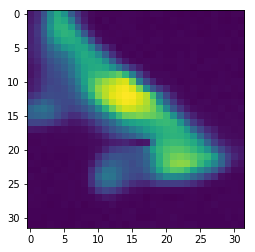

In [26]:
max_val=1.2*intensity_finder(train_norm_X)
min_val=0.8*intensity_finder(train_norm_X)
pre_array_train=pre_classifier_high_and_low_intens(train_norm_X, min_intens_cutoff=min_val,
                         max_intens_cutoff=max_val, num_blocks=7)
pre_array_valid=pre_classifier_high_and_low_intens(valid_norm_X, min_intens_cutoff=min_val,
                         max_intens_cutoff=max_val, num_blocks=7)
print(sum(pre_array_valid))
print(len(train_norm_X))
print(pre_array_valid[0:50])
plt.imshow(train_images_pre[45])

pre_array_total=np.concatenate((pre_array_train,pre_array_valid),axis=0)
pre_array_total.shape

In [37]:
counter =0
for i in range(len(pre_array_total)):
    if pre_array_total[i] == 1:
        counter += 1
        
counter
    
im = train_images_pre[45].copy()
im.size
np.sqrt(1024)

32.0

#### Add in the pre-classifier after the model has predicted, when calculating true and false pos/neg etc...

In [12]:
def model_main(pre_class_vector, pixel_size=32,drop_out=0.4,l2=0.0001,epochs = 10,batch_size = 100):
    print('Trained on '+str(len(train_labels)))
    print('Validated on '+str(len(validate_labels)))

    model_binary_classifier = create_model(pixel_size=pixel_size,drop_out=drop_out,l2=l2)
    model_binary_classifier.summary()
    model_binary_classifier = compile_model(model_binary_classifier)

    val_loss, val_acc = train_model(model_binary_classifier,train_images,train_labels,validate_images,validate_labels,epochs,batch_size)


    true_positive = []
    false_positive = []
    true_negative = []
    false_negative = []
    for i in tqdm(range(len(validate_labels))):
            vector_for_labels = np.zeros(shape=len(validate_labels))
            label = validate_labels[i][0]
            pre_class_label = pre_class_vector[i]
            #Vector here of all the pre-classified 1's or 0's.  pre_class_vector[n-length]
            prediction = model_binary_classifier.predict(validate_images[i:i+1])
            if prediction>0.5 and pre_class_label!=1: #Joint conditonal (and pre_class_label != 1)
                prediction = 1
                #Accuracies for pre-class+CNN together. 
            else:
                prediction = 0
            if (prediction == label):
                if (label == 1):
                    true_positive.append(validate_images[i:i+1])
                    prnt = "True positive"
                else:
                    true_negative.append(validate_images[i:i+1])
                    prnt = "True negative"
            else:
                if (label == 1):
                    false_negative.append(validate_images[i:i+1])
                    prnt = "False negative"
                else:
                    false_positive.append(validate_images[i:i+1])
                    prnt = "False positive"
            if (i<5):
                print('------------------------------------------')
                print(prnt)
                print('Label = ', binary_dict[label]," = ", label)
                print('prediction = ', prediction)
                plt.clf()
                plt.imshow(validate_images[i][:,:,0])
                plt.show()
        
    n_true_positive = np.shape(true_positive)[0]
    n_false_positive = np.shape(false_positive)[0]
    n_true_negative = np.shape(true_negative)[0]
    n_false_negative = np.shape(false_negative)[0]
    
    total_test = n_true_positive + n_false_positive + n_true_negative + n_false_negative

    percent_true_positive = 100 * n_true_positive/total_test
    percent_false_positive = 100 *n_false_positive/total_test
    percent_true_negative = 100 *n_true_negative/total_test
    percent_false_negative = 100 *n_false_negative/total_test

    return model_binary_classifier,percent_true_positive,percent_false_positive,percent_true_negative,percent_false_negative
    
    return

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Trained on 18652
Validated on 4663
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________

  0%|          | 0/4663 [00:00<?, ?it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


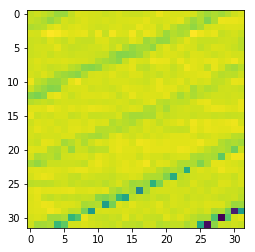

  0%|          | 1/4663 [00:00<20:56,  3.71it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


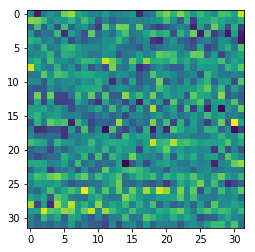

  0%|          | 2/4663 [00:00<20:47,  3.74it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


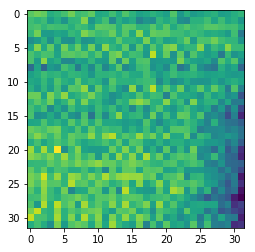

  0%|          | 3/4663 [00:00<18:13,  4.26it/s]

------------------------------------------
False negative
Label =  Bias triangle  =  1
prediction =  0


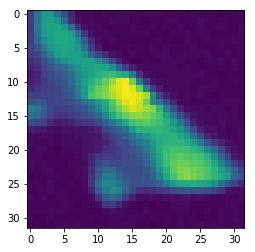

  0%|          | 4/4663 [00:00<16:44,  4.64it/s]

------------------------------------------
False negative
Label =  Bias triangle  =  1
prediction =  0


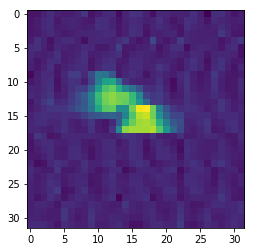

100%|██████████| 4663/4663 [02:54<00:00, 26.73it/s]


Trained on 18652
Validated on 4663
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)    

  0%|          | 0/4663 [00:00<?, ?it/s]

------------------------------------------
False negative
Label =  Bias triangle  =  1
prediction =  0


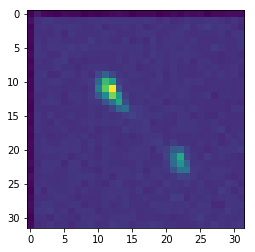

  0%|          | 1/4663 [00:00<20:49,  3.73it/s]

------------------------------------------
False positive
Label =  No triangle  =  0
prediction =  1


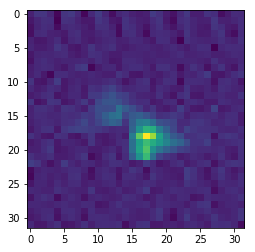

  0%|          | 2/4663 [00:00<18:25,  4.22it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


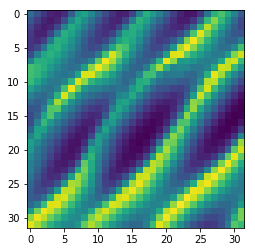

  0%|          | 3/4663 [00:00<16:23,  4.74it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


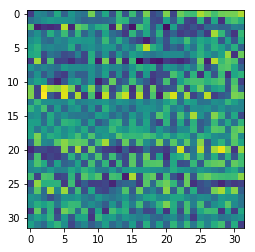

  0%|          | 4/4663 [00:00<14:57,  5.19it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


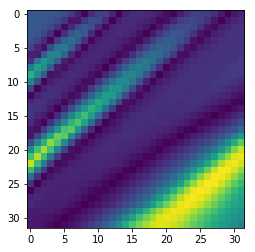

100%|██████████| 4663/4663 [03:06<00:00, 24.95it/s]


Trained on 18652
Validated on 4663
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_6 (Dense)    

  0%|          | 0/4663 [00:00<?, ?it/s]

------------------------------------------
False negative
Label =  Bias triangle  =  1
prediction =  0


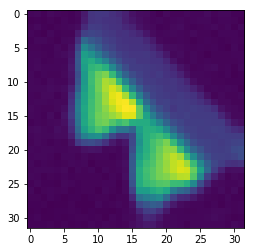

  0%|          | 1/4663 [00:00<21:13,  3.66it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


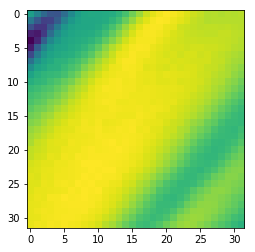

  0%|          | 2/4663 [00:00<18:55,  4.10it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


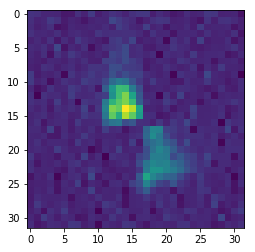

  0%|          | 3/4663 [00:00<17:11,  4.52it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


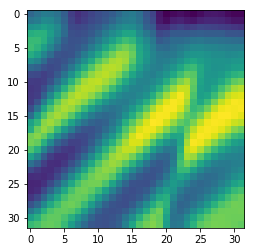

  0%|          | 4/4663 [00:00<15:38,  4.96it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


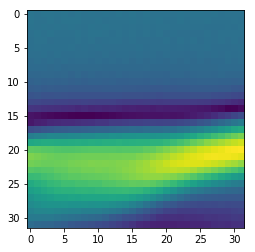

100%|██████████| 4663/4663 [04:13<00:00, 18.41it/s]  


CPU times: user 44min 24s, sys: 11min 48s, total: 56min 13s
Wall time: 25min 18s


In [13]:
%%time
perc_true_positive_tot = []
perc_false_positive_tot = []
perc_true_negative_tot = []
perc_false_negative_tot = []


for i in range(3):

    def myfunction():
        return 0.9
    z=np.arange(len(data_total))
    random.shuffle(z)
    images_copy=data_total.copy()
    images_shuffle=data_total.copy()
    labels_copy=labels_total.copy()
    labels_shuffle=labels_total.copy()
    for i in range(len(data_total)):
        images_shuffle[i]=images_copy[z[i]]
        labels_shuffle[i]=labels_copy[z[i]]   
    images_shuffle,labels_shuffle = normalise(images_shuffle,labels_shuffle) 
    val_split = 0.2
    val_set = np.int(val_split*np.shape(labels_shuffle)[0])
    train_images= np.array(images_shuffle[val_set:]).reshape(-1, 32, 32, 1)
    train_labels = np.array(labels_shuffle[val_set:]).reshape(-1, 1)
    validate_images = np.array(images_shuffle[:val_set]).reshape(-1, 32, 32, 1)
    validate_labels = np.array(labels_shuffle[:val_set]).reshape(-1, 1)
    
    
    train_images_pre=np.squeeze(train_images)
    train_labels_pre=np.squeeze(train_labels)
    validate_images_pre=np.squeeze(validate_images)
    validate_labels_pre=np.squeeze(validate_labels)
    
    train_X=block_splitting(train_images_pre)
    train_Y=train_labels
    valid_X=block_splitting(validate_images_pre)
    valid_Y=validate_labels
    
    min_max_array=min_max(train_X)
    train_norm_X=normaliser(train_X,min_max_array)
    min_max_check=min_max(train_norm_X)
    valid_norm_X=normaliser(valid_X,min_max_array)
    min_max_check=min_max(valid_norm_X)
    ave_intens=intensity_finder(train_norm_X)
    
    
    max_val=1.3*intensity_finder(train_norm_X)
    min_val=0.7*intensity_finder(train_norm_X)
    pre_array_train=pre_classifier_high_and_low_intens(train_norm_X, min_intens_cutoff=min_val,
                             max_intens_cutoff=max_val, num_blocks=8)
    pre_array_valid=pre_classifier_high_and_low_intens(valid_norm_X, min_intens_cutoff=min_val,
                             max_intens_cutoff=max_val, num_blocks=8)
    pre_array_total=np.concatenate((pre_array_train,pre_array_valid),axis=0)

    
    model_binary_classifier,percent_true_positive, percent_false_positive,percent_true_negative,percent_false_negative = model_main(pre_class_vector=pre_array_valid)

    perc_true_positive_tot.append(percent_true_positive)
    perc_false_positive_tot.append(percent_false_positive)
    perc_true_negative_tot.append(percent_true_negative)
    perc_false_negative_tot.append(percent_false_negative)

Trained on 13057
Validated on 3264
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)        

  0%|          | 0/3264 [00:00<?, ?it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


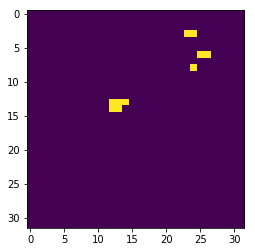

  0%|          | 1/3264 [00:00<13:03,  4.17it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


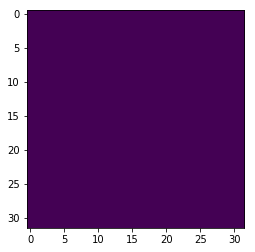

  0%|          | 2/3264 [00:00<13:38,  3.99it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


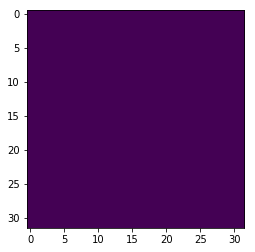

  0%|          | 3/3264 [00:00<12:09,  4.47it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


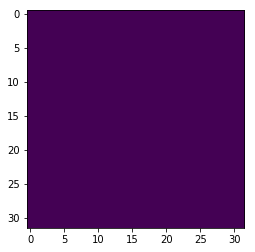

  0%|          | 4/3264 [00:00<10:56,  4.97it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


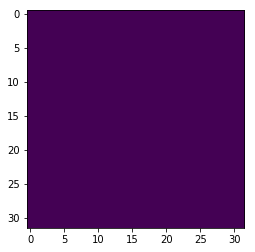

100%|██████████| 3264/3264 [01:53<00:00, 28.87it/s]


Trained on 13057
Validated on 3264
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)    

  0%|          | 0/3264 [00:00<?, ?it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


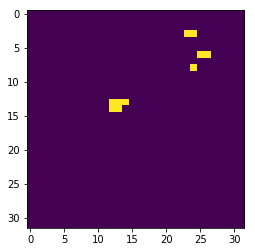

  0%|          | 1/3264 [00:00<12:34,  4.32it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


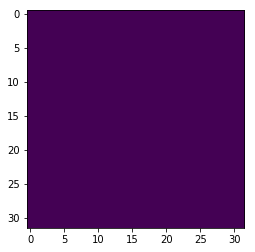

  0%|          | 2/3264 [00:00<11:12,  4.85it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


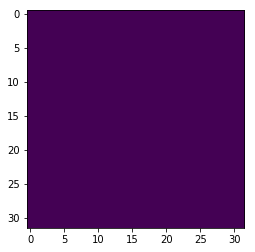

  0%|          | 3/3264 [00:00<10:15,  5.30it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


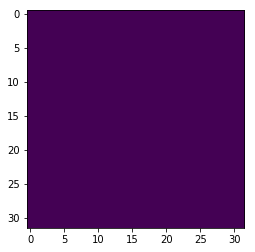

  0%|          | 4/3264 [00:00<09:32,  5.69it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


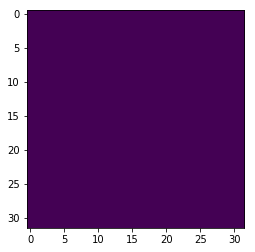

100%|██████████| 3264/3264 [02:01<00:00, 26.77it/s]


Trained on 13057
Validated on 3264
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_6 (Dense)    

  0%|          | 0/3264 [00:00<?, ?it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


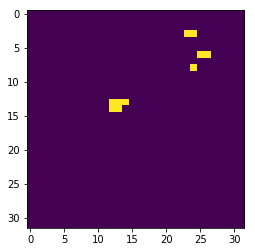

  0%|          | 1/3264 [00:00<14:22,  3.78it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


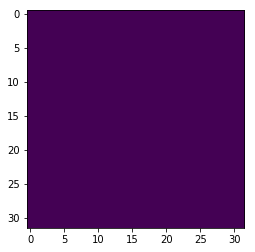

  0%|          | 2/3264 [00:00<12:41,  4.28it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


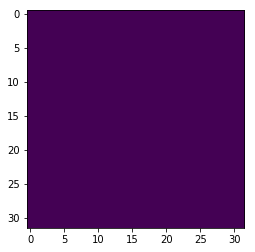

  0%|          | 3/3264 [00:00<11:21,  4.78it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


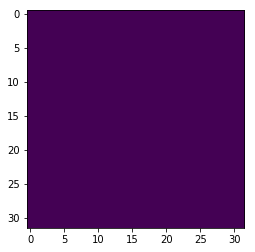

  0%|          | 4/3264 [00:00<10:30,  5.17it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


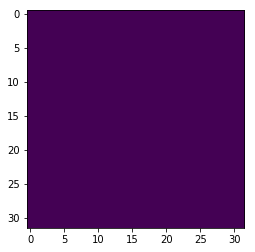

100%|██████████| 3264/3264 [01:59<00:00, 27.28it/s]


Trained on 13057
Validated on 3264
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_9 (Dense)    

  0%|          | 0/3264 [00:00<?, ?it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


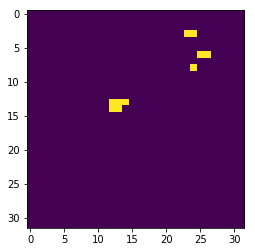

  0%|          | 1/3264 [00:00<13:24,  4.06it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


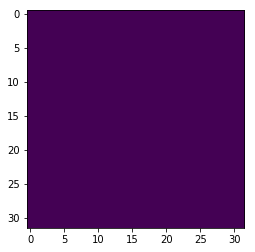

  0%|          | 2/3264 [00:00<11:51,  4.58it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


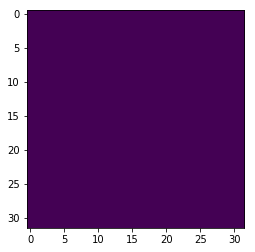

  0%|          | 3/3264 [00:00<10:51,  5.00it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


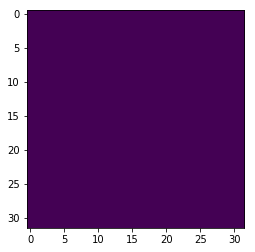

  0%|          | 4/3264 [00:00<10:02,  5.41it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


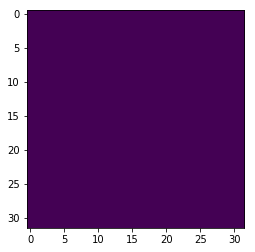

100%|██████████| 3264/3264 [02:58<00:00, 18.33it/s]  


Trained on 13057
Validated on 3264
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_12 (Dense)   

  0%|          | 0/3264 [00:00<?, ?it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


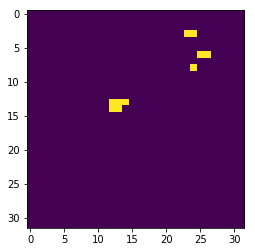

  0%|          | 1/3264 [00:00<19:48,  2.75it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


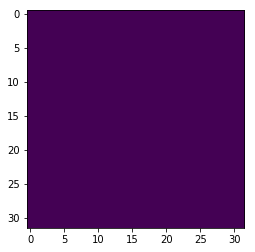

  0%|          | 2/3264 [00:00<16:49,  3.23it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


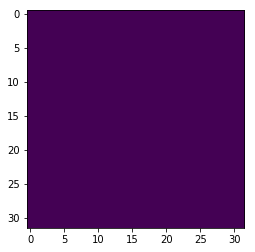

  0%|          | 3/3264 [00:00<14:31,  3.74it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


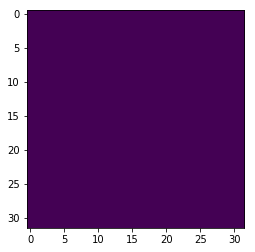

  0%|          | 4/3264 [00:00<12:35,  4.31it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


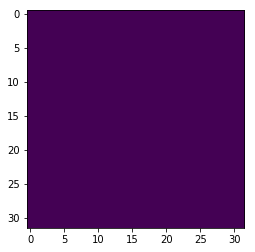

100%|██████████| 3264/3264 [03:28<00:00, 15.67it/s]  


Trained on 13057
Validated on 3264
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_15 (Dense)   

  0%|          | 0/3264 [00:00<?, ?it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


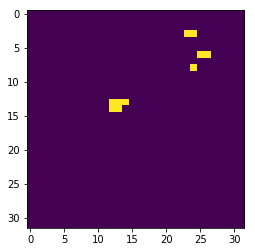

  0%|          | 1/3264 [00:00<25:14,  2.15it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


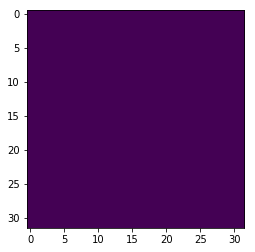

  0%|          | 2/3264 [00:00<20:53,  2.60it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


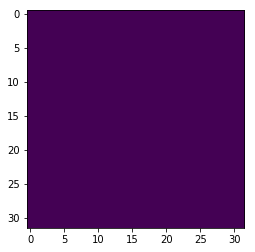

  0%|          | 3/3264 [00:00<17:29,  3.11it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


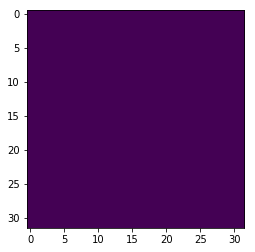

  0%|          | 4/3264 [00:01<14:56,  3.64it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


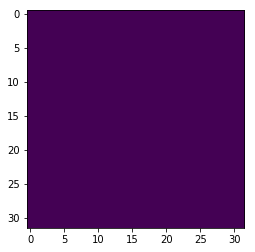

100%|██████████| 3264/3264 [05:02<00:00, 10.79it/s]  


Trained on 13057
Validated on 3264
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_6 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_18 (Dense)   

  0%|          | 0/3264 [00:00<?, ?it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


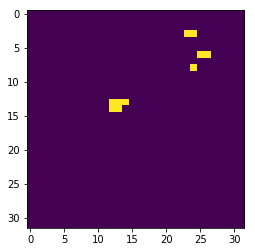

  0%|          | 1/3264 [00:00<42:11,  1.29it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


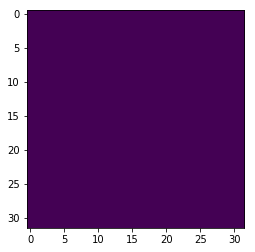

  0%|          | 2/3264 [00:01<33:57,  1.60it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


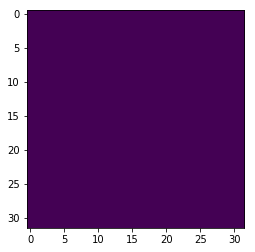

  0%|          | 3/3264 [00:01<27:43,  1.96it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


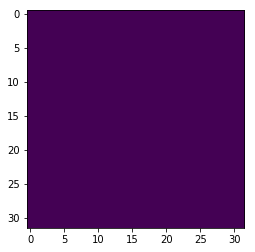

  0%|          | 4/3264 [00:01<22:39,  2.40it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


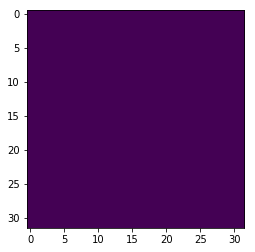

100%|██████████| 3264/3264 [02:07<00:00, 25.68it/s]


Trained on 13057
Validated on 3264
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_7 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_21 (Dense)   

  0%|          | 0/3264 [00:00<?, ?it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


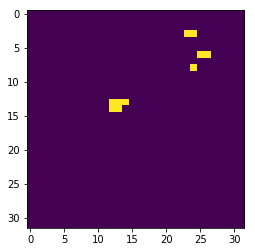

  0%|          | 1/3264 [00:00<13:42,  3.97it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


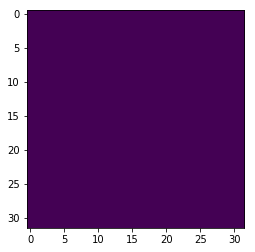

  0%|          | 2/3264 [00:00<12:02,  4.52it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


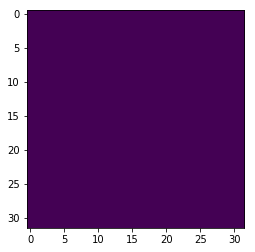

  0%|          | 3/3264 [00:00<10:46,  5.04it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


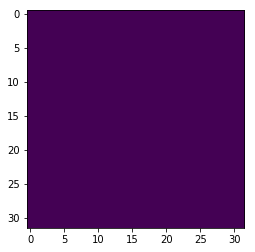

  0%|          | 4/3264 [00:00<09:57,  5.46it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


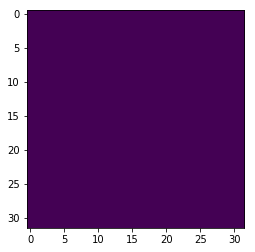

100%|██████████| 3264/3264 [06:10<00:00,  8.81it/s]  


Trained on 13057
Validated on 3264
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_8 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_24 (Dense)   

  0%|          | 0/3264 [00:00<?, ?it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


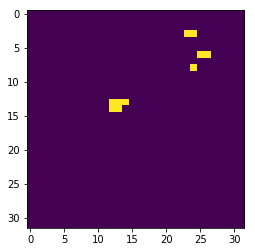

  0%|          | 1/3264 [00:00<34:43,  1.57it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


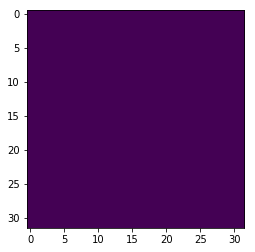

  0%|          | 2/3264 [00:00<28:30,  1.91it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


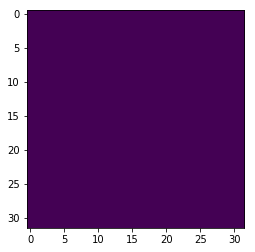

  0%|          | 3/3264 [00:01<24:00,  2.26it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


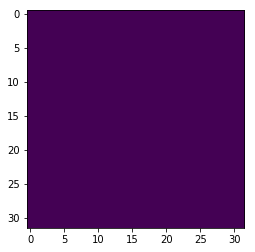

  0%|          | 4/3264 [00:01<20:11,  2.69it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


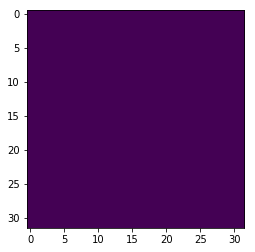

100%|██████████| 3264/3264 [44:10<00:00,  1.23it/s]     


Trained on 13057
Validated on 3264
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_9 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_27 (Dense)   

  0%|          | 0/3264 [00:00<?, ?it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


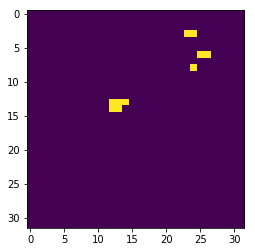

  0%|          | 1/3264 [00:00<47:12,  1.15it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


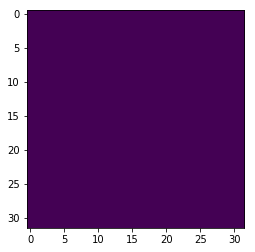

  0%|          | 2/3264 [00:01<38:16,  1.42it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


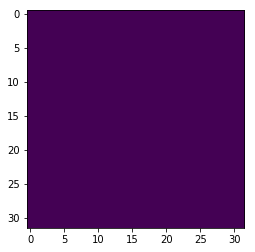

  0%|          | 3/3264 [00:01<31:03,  1.75it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


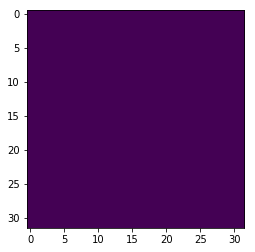

  0%|          | 4/3264 [00:01<26:23,  2.06it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


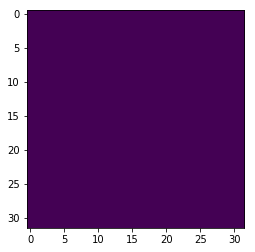

100%|██████████| 3264/3264 [02:48<00:00, 19.42it/s]


Do a run with no shuffle to test two things:
1) does not having shuffle make the pre-classification actually make some sense and be better?
2) does not having shuffle make all runs have the same accuracy (or closer accuracy?) and is the pattern of results the same as the same run but with shuffle? 

In [38]:
perc_false_positive_tot

[0.6219172206733863, 0.879262277503753]

In [14]:
import csv
total_dict = {'1': perc_false_positive_tot, 
         '2': perc_false_negative_tot, 
         '3': perc_true_positive_tot, 
         '4': perc_true_negative_tot
        }
 
keys = sorted(total_dict.keys())
with open("CNN_CPCPC_PreBlocks1307_blocks8_3runs.csv", "w") as outfile:
    writer = csv.writer(outfile, delimiter = "\t")
    writer.writerow(keys)
    writer.writerows(zip(*[total_dict[key] for key in keys]))

In [18]:
cwd = os.chdir(primary_dir)
model_binary_classifier.save('bias_triangle_binary_classifier.h5')

In [19]:
print('Percent true positive  ',n_true_positive)
print('Percent false positive  ',n_false_positive)
print('Percent true negative  ',n_true_negative)
print('Percent false negative  ',n_false_negative)
print('Percent Total True   ',(n_true_positive + n_true_negative))

Percent true positive   11.090686274509803
Percent false positive   0.42892156862745096
Percent true negative   80.88235294117646
Percent false negative   7.598039215686274
Percent Total True    91.97303921568627


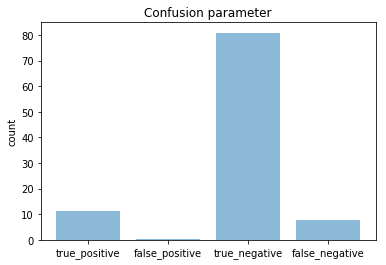

In [20]:
objects = ('true_positive','false_positive','true_negative','false_negative')
y_pos = np.arange(len(objects))
performance = [n_true_positive,n_false_positive,n_true_negative,n_false_negative]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('count')
plt.title('Confusion parameter')

plt.show()

Pre-Class Results

Initial trial looks like it reduces the number of positives all round. (incl. False positives)

Without Pre-Class:
Percent true positive   12.10171568627451 %
Percent false positive   1.133578431372549 %
Percent true negative   80.17769607843137 %
Percent false negative   6.5870098039215685 %
Percent Total True    92.27941176470588 %

With (Blocks= 7 Max=1.3 min=0.8):
Percent true positive   10.876225490196079 %
Percent false positive   0.5208333333333334 %
Percent true negative   80.7904411764706 %
Percent false negative   7.8125 %
Percent Total True    91.66666666666667 %

(Blocks=7, Max=1.3, Min=0):
Percent true positive   11.151960784313726 %
Percent false positive   0.49019607843137253 %
Percent true negative   80.82107843137256 %
Percent false negative   7.536764705882353 %
Percent Total True    91.97303921568628 %

(Blocks=7, Max=1.15, min=0)
Percent true positive   10.876225490196079 %
Percent false positive   0.6127450980392157 %
Percent true negative   80.69852941176471 %
Percent false negative   7.8125 %
Percent Total True    91.57475490196079 %

(Blocks=8, Max=1.15, min=0)
Percent true positive   11.213235294117647 %
Percent false positive   0.7352941176470589 %
Percent true negative   80.57598039215686 %
Percent false negative   7.4754901960784315 %
Percent Total True    91.78921568627452 %

(Blocks=9, Mac=1.15, min=0)
Percent true positive   10.784313725490197 %
Percent false positive   0.33700980392156865 %
Percent true negative   80.97426470588235 %
Percent false negative   7.904411764705882 %
Percent Total True    91.75857843137254 %

(blocks=9, Max=1.1, min=0)
Percent true positive   11.121323529411764 %
Percent false positive   0.7046568627450981 %
Percent true negative   80.60661764705883 %
Percent false negative   7.567401960784314 %
Percent Total True    91.7279411764706 %

(blocks=9, max=1.1, min=0) [Same as Above to test for noise] [NOISY]
Percent true positive   10.661764705882353 %
Percent false positive   0.42892156862745096 %
Percent true negative   80.88235294117646 %
Percent false negative   8.026960784313726 %
Percent Total True    91.54411764705881 %

Corrrect Block Indexing:(blocks=9, max=1.1, min=0)
Percent true positive   10.661764705882353 %
Percent false positive   0.36764705882352944 %
Percent true negative   80.94362745098039 %
Percent false negative   8.026960784313726 %
Percent Total True    91.60539215686273 %